In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import requests
import json

### Importing main file 'papers.csv'

In [2]:
df=pd.read_csv('papers.csv')
print(len(df))
print(df.columns)

49317
Index(['Conference', 'Year', 'Title', 'Author', 'Affiliation'], dtype='object')


In [3]:
# dataframe for doing citations related analysis
df_citations=pd.DataFrame(columns=df.columns)

#### Merging the papers with same title 

In [4]:
i=0
while i<len(df):
    title=df.loc[i,'Title']
    ct=i
    conf=df.loc[i,'Conference']
    year=df.loc[i,'Year']
    authors=[]
    aff=[]
    while ct<len(df) and df.loc[ct,'Title']==title:
        authors.append(df.loc[ct,'Author'])
        aff.append(df.loc[ct,'Affiliation'])
        i=i+1
        ct=ct+1
    df_citations.loc[len(df_citations)]=[conf,year,title,authors,aff]

### Getting citations for each paper from title using Semantic Scholar API

,Year,Count
0,2006,204
1,2007,217
2,2008,250
3,2009,262
4,2010,292
5,2011,306
6,2012,368
7,2013,360
8,2014,411
9,2015,403


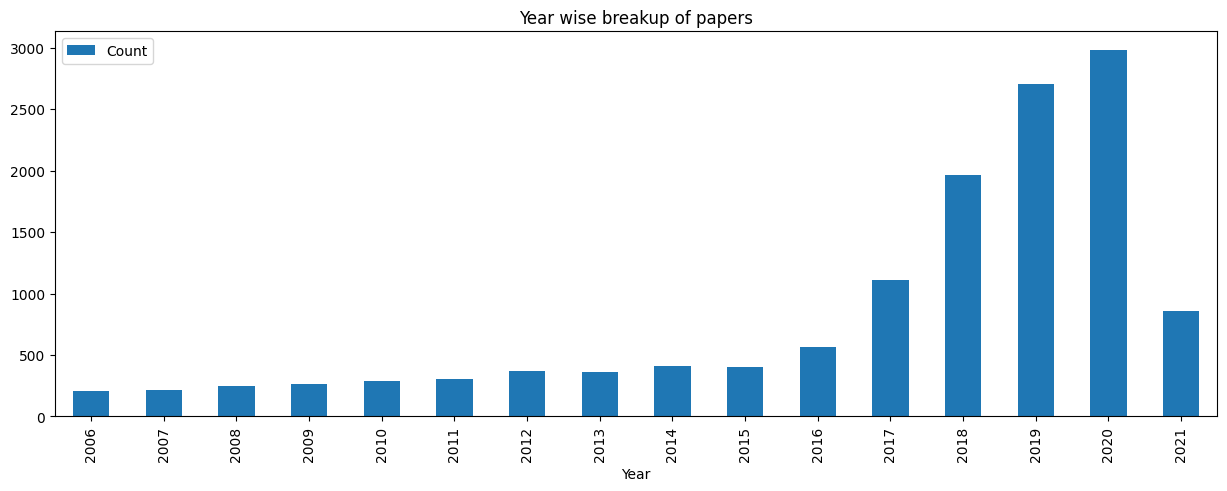

In [5]:
# year wise breakup of papers
year_wise_df=pd.DataFrame(columns=['Year','Count'])
start_year=df_citations['Year'].min()
end_year=df_citations['Year'].max()
for i in range(start_year,end_year+1):
    year_wise_df.loc[len(year_wise_df)]=[i,len(df_citations[df_citations['Year']==i])]
year_wise_df.plot(x='Year',y='Count',kind='bar',figsize=(15,5),title='Year wise breakup of papers')
year_wise_df


In [8]:
# number of papers till 2012
print(len(df_citations[df_citations['Year']<=2012]))

# number of papers till 2015
print(len(df_citations[df_citations['Year']<=2015]))

1899
3073


In [9]:
len(df_citations)

13263

In [11]:
error_rate=0
citation_graph=pd.DataFrame(columns=['PaperId','Cited_PaperId'])
for i in tqdm.trange(len(df_citations[df_citations['Year']<=2012])):
    title=df_citations.loc[i,'Title']
    try:
        # getting id by title
        query="http://api.semanticscholar.org/graph/v1/paper/search?query="+title
        req=requests.get(query)
        response=req.json()
        id=response['data'][0]['paperId']
        citation_graph.loc[i]=[id,[]]

        # getting citations by id
        search_by_id="https://api.semanticscholar.org/graph/v1/paper/"+id+"?fields=title,citations.authors,authors"
        req=requests.get(search_by_id)
        response=dic2=json.loads(req.content.decode('utf-8'))
        
        for citation in response['citations']:
            citation_graph.loc[i,'Cited_PaperId'].append(citation['paperId'])
        
    except:
        error_rate=error_rate+1
    if(i%100==0):
        print(error_rate/(i+1))
        citation_graph.to_csv('citation_graph_2012.csv',index=False)

print(error_rate/len(df_citations[df_citations['Year']<=2012]))
citation_graph.to_csv('citation_graph_2012.csv',index=False)


100%|██████████| 1899/1899 [1:44:32<00:00,  3.30s/it]  


0.2553975776724592


In [10]:
citation_graph=pd.read_csv('citation_data/citation_graph_2012_with_country.csv')
citation_graph.head()
print(type(citation_graph.loc[0,'Cited_PaperId']))

<class 'str'>


In [11]:
# reset index
citation_graph=citation_graph.reset_index(drop=True)

In [14]:
for i in tqdm.trange(len(citation_graph)):
    citation_graph.loc[i,"Cited_PaperId"]=eval(citation_graph.loc[i,'Cited_PaperId'])
citation_graph.head()

  0%|          | 0/1414 [00:00<?, ?it/s]


TypeError: eval() arg 1 must be a string, bytes or code object

In [25]:
len(citation_graph)
print(citation_graph.columns)
type(citation_graph.loc[0,'Cited_PaperId'])


Index(['PaperId', 'Cited_PaperId', 'Title', 'Country'], dtype='object')


list

In [16]:
# creating the citation graph
# include only those which are cited by any other paper atleast once
# no of citations are the number of times it is cited by other papers in the dataset

# convert id to index 
id_to_index={}
index_to_id={}
for i in tqdm.trange(len(citation_graph)):
    # print(citation_graph['PaperId'][i])
    id_to_index[citation_graph.loc[i,'PaperId']]=i
    index_to_id[i]=citation_graph.loc[i,'PaperId']


100%|██████████| 1414/1414 [00:00<00:00, 35314.25it/s]


In [27]:
from pyvis.network import Network
net=Network(notebook=True)
graph={}
for i in range(len(citation_graph)):
    graph[i]={'country':'None','Cited_PaperId':[]}
    graph[i]['country']=citation_graph.loc[i,'Country']
    for j in citation_graph.loc[i,'Cited_PaperId']:
        if j in id_to_index:
            graph[i]['Cited_PaperId'].append(id_to_index[j])

# save the graph as json
with open('citation_graph_2012.json', 'w') as fp:
    json.dump(graph, fp)


100%|██████████| 1414/1414 [00:00<00:00, 29712.86it/s]

[(287, 9), (321, 9), (520, 9), (105, 8), (46, 7), (234, 7), (296, 7), (396, 7), (565, 7), (21, 6), (30, 6), (90, 6), (163, 6), (241, 6), (262, 6), (571, 6), (703, 6), (24, 5), (191, 5), (208, 5), (237, 5), (256, 5), (266, 5), (553, 5), (555, 5), (1029, 5), (18, 4), (85, 4), (99, 4), (172, 4), (173, 4), (185, 4), (190, 4), (229, 4), (253, 4), (274, 4), (280, 4), (286, 4), (319, 4), (374, 4), (466, 4), (495, 4), (561, 4), (562, 4), (564, 4), (677, 4), (682, 4), (697, 4), (883, 4), (918, 4), (949, 4), (89, 3), (92, 3), (96, 3), (104, 3), (141, 3), (224, 3), (248, 3), (254, 3), (255, 3), (271, 3), (290, 3), (317, 3), (318, 3), (347, 3), (372, 3), (373, 3), (400, 3), (447, 3), (451, 3), (463, 3), (473, 3), (475, 3), (479, 3), (530, 3), (543, 3), (566, 3), (573, 3), (631, 3), (643, 3), (653, 3), (713, 3), (716, 3), (746, 3), (755, 3), (799, 3), (806, 3), (823, 3), (828, 3), (858, 3), (929, 3), (996, 3), (1000, 3), (1006, 3), (1050, 3), (1128, 3), (3, 2), (4, 2), (11, 2), (29, 2), (32, 2), (3

Text(0.5, 1.0, 'Citation count of papers')

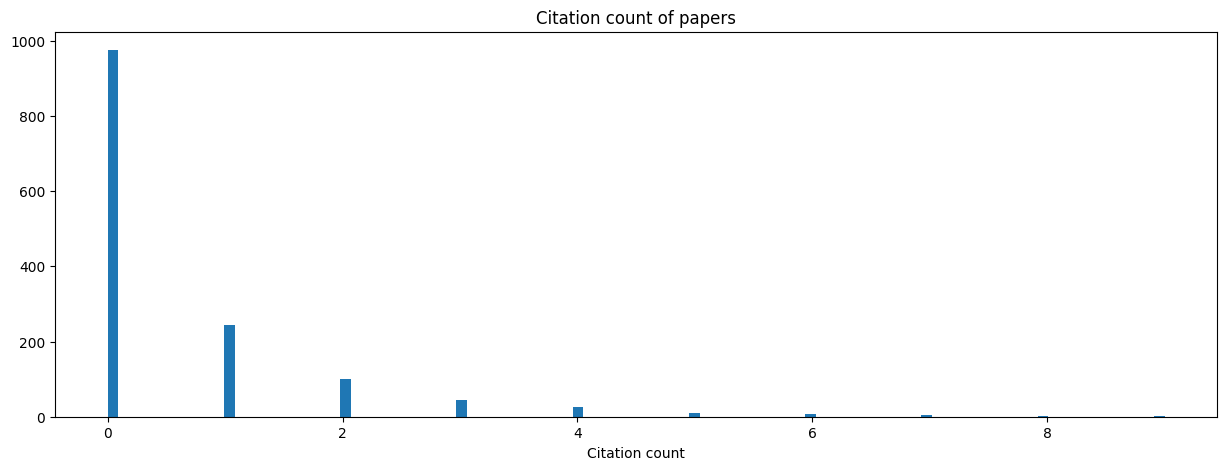

In [18]:
# count of papers which are cited by other papers
citation_count={}
for i in tqdm.trange(len(citation_graph)):
    citation_count[i]=0
    for j in citation_graph.loc[i,'Cited_PaperId']:
        if j in id_to_index:
            citation_count[i]=citation_count[i]+1



# sort the citation count
sorted_citation_count=sorted(citation_count.items(), key=lambda x: x[1],reverse=True)
print(sorted_citation_count)

# plot the citation count
plt.figure(figsize=(15,5))
# frequency of citation count
plt.hist(citation_count.values(),bins=100)
plt.xlabel('Citation count')
plt.title('Citation count of papers')


In [19]:
# no of papers with citation count greater than 0
print(len([i for i in citation_count.values() if i>0]))

citation_count_1=[i for i in citation_count.values() if i>0]
citation_count_1

439


[2,
 2,
 1,
 1,
 2,
 1,
 4,
 6,
 1,
 5,
 1,
 2,
 6,
 2,
 1,
 2,
 1,
 1,
 2,
 7,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 3,
 6,
 3,
 1,
 3,
 4,
 1,
 3,
 8,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 6,
 2,
 2,
 2,
 1,
 2,
 4,
 4,
 2,
 1,
 2,
 2,
 2,
 4,
 4,
 5,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 5,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 4,
 1,
 2,
 7,
 1,
 1,
 5,
 6,
 1,
 1,
 2,
 3,
 2,
 2,
 1,
 4,
 3,
 3,
 5,
 1,
 6,
 5,
 2,
 3,
 1,
 4,
 1,
 1,
 1,
 4,
 1,
 4,
 9,
 2,
 3,
 1,
 1,
 7,
 2,
 1,
 1,
 3,
 3,
 4,
 9,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 3,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 7,
 3,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 3,
 2,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 9,
 2,
 1,
 1,
 3,
 1,
 2,
 2,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 1,
 2,
 5,
 5,
 1,
 4,
 4,
 1,
 4,
 7,
 3,
 1,
 6,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,


In [28]:
graph

{0: {'country': 'France', 'Cited_PaperId': []},
 1: {'country': 'United States', 'Cited_PaperId': []},
 2: {'country': 'United States', 'Cited_PaperId': []},
 3: {'country': 'United States', 'Cited_PaperId': [598, 373]},
 4: {'country': 'United States', 'Cited_PaperId': [1126, 781]},
 5: {'country': 'United States', 'Cited_PaperId': [393]},
 6: {'country': 'United States', 'Cited_PaperId': []},
 7: {'country': 'United States', 'Cited_PaperId': []},
 8: {'country': 'United States', 'Cited_PaperId': []},
 9: {'country': 'United States', 'Cited_PaperId': [921]},
 10: {'country': 'United States', 'Cited_PaperId': []},
 11: {'country': 'Canada', 'Cited_PaperId': [607, 485]},
 12: {'country': 'Norway', 'Cited_PaperId': []},
 13: {'country': 'United States', 'Cited_PaperId': [788]},
 14: {'country': 'United States', 'Cited_PaperId': []},
 15: {'country': 'United States', 'Cited_PaperId': []},
 16: {'country': 'United States', 'Cited_PaperId': []},
 17: {'country': 'United States', 'Cited_Pape

In [23]:
# map country to number
top_10_countries=citation_graph['Country'].value_counts()[:10].index
top_10_countries

Index(['United States', 'United Kingdom', 'Germany', 'Canada', 'France',
       'Italy', 'China', 'Israel', 'Australia', 'Switzerland'],
      dtype='object')

In [29]:
for node in graph:
    group=graph[node]['country']
    if group in top_10_countries:
        # change str to index in top 10 countries
        group=top_10_countries.get_loc(group)
    else:
        group=10
    net.add_node(node,size=citation_count[node],group=group)


# add edges
for node in graph:
    
    for edge in graph[node]['Cited_PaperId']:
        net.add_edge(node,edge)

net.show_buttons(filter_=['physics'])
net.save_graph('citation_data/citation_graph_2012_2.html')


In [52]:
# top 100 cited papers graph
top_100_cited_papers=[index_to_id[i[0]] for i in sorted_citation_count[:100]]

# create a subgraph of top 100 cited papers
top_100_cited_papers_graph={}
for i in tqdm.trange(len(citation_graph)):
    if citation_graph.loc[i,'PaperId'] in top_100_cited_papers:
        top_100_cited_papers_graph[i]=[]
        for j in citation_graph.loc[i,'Cited_PaperId']:
            if j in id_to_index:
                top_100_cited_papers_graph[i].append(id_to_index[j])

# save the graph as json
with open('citation_graph_2012_top_100.json', 'w') as fp:
    json.dump(top_100_cited_papers_graph, fp)
    

100%|██████████| 1414/1414 [00:00<00:00, 6107.91it/s]


In [54]:
# visualize the graph
net=Network(notebook=True)
for node in top_100_cited_papers_graph:
    net.add_node(node,size=citation_count[node])

# add edges
for node in top_100_cited_papers_graph:
    for edge in top_100_cited_papers_graph[node]:
        if edge in top_100_cited_papers_graph:
            net.add_edge(node,edge,color='red',arrowStrikethrough=True)
    
net.show_buttons(filter_=['physics'])
net.save_graph('citation_data/citation_graph_2012_top_100.html')


### Authors with most papers

In [3]:
author_count={}

for i in tqdm.tqdm(range(len(df))):
    author=df.loc[i,'Author']
    author_count[author]=author_count.get(author,0)+1
# top 100 authors
sorted_author_count=sorted(author_count.items(),key=lambda x:x[1],reverse=True)
sorted_author_count
# save as json
with open('citation_data/author_count.json','w') as f:
    json.dump(sorted_author_count,f)


100%|██████████| 49317/49317 [00:01<00:00, 37953.56it/s]


### Frequency of plot of number of papers vs number of authors

In [30]:
pass

KeyboardInterrupt: 

In [4]:
top_100_authors=sorted_author_count[:100]
top_100_authors

[('Sergey Levine', 102),
 ('Yoshua Bengio', 89),
 ('Michael Jordan', 88),
 ('Pieter Abbeel', 76),
 ('Lawrence Carin', 76),
 ('Masashi Sugiyama', 63),
 ('Francis Bach', 63),
 ('Le Song', 61),
 ('Pradeep Ravikumar', 60),
 ('Remi Munos', 58),
 ('Andreas Krause', 58),
 ('Russ Salakhutdinov', 57),
 ('Jun Zhu', 57),
 ('Stefano Ermon', 57),
 ('Yee Whye Teh', 56),
 ('Bernhard Schölkopf', 56),
 ('Tong Zhang', 56),
 ('Eric Xing', 56),
 ('Josh Tenenbaum', 52),
 ('Max Welling', 50),
 ('Csaba Szepesvari', 49),
 ('Tie-Yan Liu', 49),
 ('Inderjit Dhillon', 47),
 ('Prateek Jain', 47),
 ('Nati Srebro', 47),
 ('Cho-Jui Hsieh', 47),
 ('Mehryar Mohri', 44),
 ('Richard Zemel', 44),
 ('Honglak Lee', 43),
 ('Dale Schuurmans', 43),
 ('Qiang Liu', 42),
 ('Zhaoran Wang', 42),
 ('David Blei', 41),
 ('Percy Liang', 41),
 ('Pushmeet Kohli', 41),
 ('Han Liu', 40),
 ('Volkan Cevher', 40),
 ('Mihaela van der Schaar', 40),
 ('Shie Mannor', 39),
 ('Tommi Jaakkola', 38),
 ('Zoubin Ghahramani', 38),
 ('Quanquan Gu', 37),


In [5]:
# collobration network for top 100 authors
# edge : (author1,author2) worked on same paper
# weight : number of papers they worked on together

collobration=pd.DataFrame(columns=['Author1','Author2','Weight'])

for author1 in top_100_authors:
    for author2 in top_100_authors:
        if(author1!=author2):
            # find number of papers they worked on together using title
            
            title1=df[df['Author']==author1[0]]['Title']
            title2=df[df['Author']==author2[0]]['Title']
            
            common_papers=len(set(title1).intersection(set(title2)))
            if(common_papers>0):
                collobration.loc[len(collobration)]=[author1[0],author2[0],common_papers]
collobration=collobration.sort_values(by='Weight',ascending=False)
collobration


,Author1,Author2,Weight
159,Tie-Yan Liu,Tao Qin,34
290,Tao Qin,Tie-Yan Liu,34
449,Gang Niu,Masashi Sugiyama,28
36,Masashi Sugiyama,Gang Niu,28
211,Zhaoran Wang,Zhuoran Yang,26
...,...,...,...
230,Pushmeet Kohli,Antonio Torralba,1
229,Pushmeet Kohli,Mohammad Norouzi,1
228,Pushmeet Kohli,Shimon Whiteson,1
227,Pushmeet Kohli,Oriol Vinyals,1


In [21]:
# remove 1 from weight
collobration['Weight']=collobration['Weight']-1
# covnert int64 to int32
collobration['Weight']=collobration['Weight'].astype('int32')

### Creating Colloborative Network

In [23]:
from pyvis.network import Network
net = Network(notebook=True)

# collobration network for top 100 authors
# edge : (author1,author2) worked on same paper
# weight : number of papers they worked on together

for author in top_100_authors:
    net.add_node(author[0], size=author[1])

for i in range(len(collobration)):
    print(collobration.loc[i,'Author1'], collobration.loc[i,'Author2'], collobration.loc[i,'Weight'])
    net.add_edge(collobration.loc[i,'Author1'], collobration.loc[i,'Author2'],value=int(collobration.loc[i,'Weight']))

net.show("citation_data/collobration1.html")



Sergey Levine Yoshua Bengio 2
Sergey Levine Pieter Abbeel 16
Sergey Levine Russ Salakhutdinov -1
Sergey Levine Stefano Ermon -2
Sergey Levine Bernhard Schölkopf -2
Sergey Levine Honglak Lee 0
Sergey Levine Zoubin Ghahramani -1
Sergey Levine Chelsea Finn 22
Sergey Levine Mohammad Norouzi -2
Sergey Levine Tengyu Ma -2
Sergey Levine Quoc V Le -2
Yoshua Bengio Sergey Levine 2
Yoshua Bengio Russ Salakhutdinov -1
Yoshua Bengio Zoubin Ghahramani -2
Yoshua Bengio Aaron Courville 9
Yoshua Bengio Jascha Sohl-Dickstein -2
Yoshua Bengio Razvan Pascanu 0
Michael Jordan Francis Bach -2
Michael Jordan Le Song -1
Michael Jordan Eric Xing -2
Michael Jordan Zhaoran Wang -2
Michael Jordan Percy Liang -1
Michael Jordan Zoubin Ghahramani -2
Michael Jordan Stefanie Jegelka 0
Michael Jordan Simon Du -1
Michael Jordan Peter Bartlett 2
Michael Jordan John Duchi 2
Michael Jordan Zhuoran Yang -2
Pieter Abbeel Sergey Levine 16
Pieter Abbeel Jinwoo Shin -2
Pieter Abbeel Nicolas Heess -2
Pieter Abbeel Chelsea Finn 